# Train and validate ML model for phenotypic classification of nuclei

### Use training data with DeepProfiler features from [training_data.csv.gz](../1.format_data/data/training_data.csv.gz)

### Import libraries


In [1]:
import pandas as pd
import numpy as np
import pathlib
from typing import Tuple, Any, List, Union

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    StratifiedKFold,
    cross_validate,
    cross_val_predict,
    GridSearchCV,
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

import seaborn as sns

### Helper functions for data loading, training, and validation


In [2]:
def get_X_y_data(load_path: pathlib.Path) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """generate X (features) and y (labels) dataframes from training data

    Args:
        load_path (pathlib.Path): path to training data csv

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: X, y dataframes
    """
    # read dataset into pandas dataframe
    training_data = pd.read_csv(load_path, index_col=0)

    # remove training data with ADCCM class as this class was not used for classification in original paper
    training_data = training_data[
        training_data["Mitocheck_Phenotypic_Class"] != "ADCCM"
    ]

    # replace shape1 and shape3 labels with their correct respective classes
    training_data = training_data.replace("Shape1", "Binuclear")
    training_data = training_data.replace("Shape3", "Polylobed")

    # all features from DeepProfiler have "efficientnet" in their column name
    morphology_features = [
        col for col in training_data.columns.tolist() if "efficientnet" in col
    ]

    # extract features
    X = training_data.loc[:, morphology_features].values

    # extract phenotypic class label
    y = training_data.loc[:, ["Mitocheck_Phenotypic_Class"]].values
    # make Y data
    y = np.ravel(y)

    # shuffle data because as it comes from MitoCheck same labels tend to be in grou
    X, y = shuffle(X, y, random_state=0)

    return X, y


def average_feature_weights(
    estimator_list: List, return_pandas: bool = True
) -> Union[np.ndarray, pd.DataFrame]:
    """average coefs from list of estimators

    Args:
        estimator_list (List): list of estimators from cross_validate()
        return_pandas (bool, optional): whether or not to return pandas dataframe. If false returns numpy array. If true returns labled pandas dataframe. Defaults to True.

    Returns:
        Union[np.ndarray,pd.DataFrame]: average coefs array or average coefs pandas dataframe
    """

    coefs = []
    for estimator in estimator_list:
        coefs.append(estimator.coef_)

    average_coefs = np.mean(coefs, axis=0)
    # get abs
    average_coefs = np.abs(average_coefs)

    if not return_pandas:
        return average_coefs

    average_coefs = pd.DataFrame(average_coefs).T
    classes = estimator_list[0].classes_
    average_coefs.columns = classes

    return average_coefs


In [3]:
# load x (features) and y (labels) dataframes
load_path = pathlib.Path("../1.format_data/data/training_data.csv.gz")
X, y = get_X_y_data(load_path)

print(X.shape)
print(y.shape)

# create stratified data sets for k-fold cross validation
straified_k_folds = StratifiedKFold(n_splits=10, shuffle=False)

(4123, 1280)
(4123,)


In [4]:
# create logistic regression model with following parameters
log_reg_model = LogisticRegression(
    penalty="elasticnet", solver="saga", max_iter=100, n_jobs=-1, random_state=0
)

In [5]:
# hypertune parameters with GridSearchCV
parameters = {"C": np.logspace(-3, 3, 7), "l1_ratio": np.linspace(0, 1, 11)}
#parameters = {"C": [1.0], "l1_ratio": [0.8]}
print(f"Parameters being tested: {parameters}")
grid_search_cv = GridSearchCV(
    log_reg_model, parameters, cv=straified_k_folds, n_jobs=-1
)
grid_search_cv = grid_search_cv.fit(X, y)

Parameters being tested: {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), 'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}


/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklea

In [6]:
print("Best parameters: ", grid_search_cv.best_params_)
log_reg_model = LogisticRegression(
    C=grid_search_cv.best_params_["C"],
    l1_ratio=grid_search_cv.best_params_["l1_ratio"],
    penalty="elasticnet",
    solver="saga",
    max_iter=100,
    n_jobs=-1,
    random_state=0,
)

Best parameters:  {'C': 1.0, 'l1_ratio': 0.8}


In [7]:
# cross validation with logistic regression model across stratified data sets
cv_results = cross_validate(
    log_reg_model, X, y, cv=straified_k_folds, n_jobs=-1, return_estimator=True
)
avg_score = np.mean(cv_results["test_score"])
print(f"Average score: {avg_score}")

/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklea

Average score: 0.8103316956204895


/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/sklea

<Figure size 432x288 with 0 Axes>

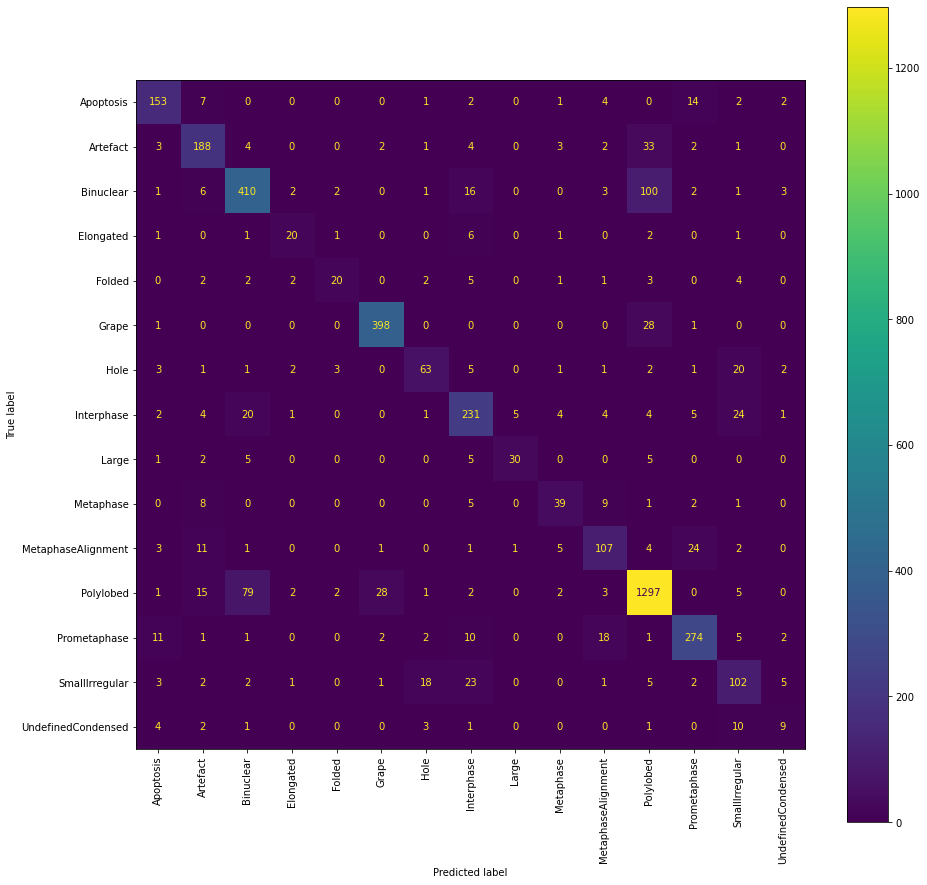

In [8]:
# create confusion matrix for logistic regression model after cross validation
y_pred = cross_val_predict(log_reg_model, X, y, cv=straified_k_folds, n_jobs=-1)
conf_mat = confusion_matrix(y, y_pred, labels=grid_search_cv.best_estimator_.classes_)

# display confusion matrix
plt.clf()
plt.rcParams["figure.figsize"] = [15, 15]
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_mat, display_labels=grid_search_cv.best_estimator_.classes_
)
disp.plot()
plt.xticks(rotation=90)
plt.show()

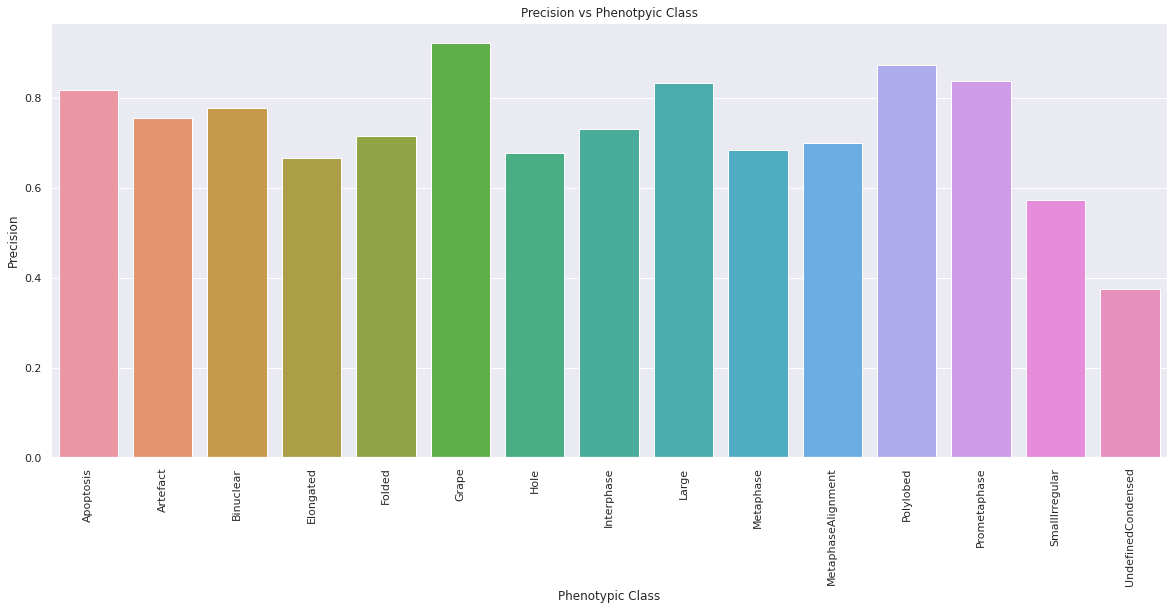

In [9]:
# display precision vs phenotypic class bar chart
precisions = precision_score(y, y_pred, average=None)
precisions = pd.DataFrame(precisions).T
precisions.columns = columns=cv_results["estimator"][0].classes_

sns.set(rc={"figure.figsize": (20, 8)})
plt.xlabel("Phenotypic Class")
plt.ylabel("Precision")
plt.title("Precision vs Phenotpyic Class")
plt.xticks(rotation=90)
ax = sns.barplot(data=precisions)

In [10]:
# get average coefs across all estimators in cross validation
average_coefs = average_feature_weights(cv_results["estimator"])
print(average_coefs.shape)
average_coefs.head()

(1280, 15)


,Apoptosis,Artefact,Binuclear,Elongated,Folded,Grape,Hole,Interphase,Large,Metaphase,MetaphaseAlignment,Polylobed,Prometaphase,SmallIrregular,UndefinedCondensed
0,6.574467e-03,0.012547,0.042743,0.006460,0.028214,0.021126,0.016715,0.031769,0.021266,0.004620,0.055100,0.025562,0.050074,0.104169,0.000000
1,1.275663e-08,0.010068,0.060941,0.000083,0.060196,0.038429,0.020561,0.050236,0.000000,0.001908,0.000000,0.092453,0.000085,0.031067,0.000000
2,6.841998e-03,0.054538,0.012703,0.000348,0.000083,0.000000,0.012569,0.023740,0.000132,0.000372,0.035392,0.148364,0.027245,0.058929,0.014372
3,8.614706e-04,0.026595,0.085369,0.026333,0.000045,0.026770,0.054080,0.168974,0.006255,0.027852,0.018826,0.029939,0.003297,0.000354,0.000000
4,6.233282e-02,0.077192,0.114688,0.000307,0.003276,0.003408,0.035008,0.001890,0.000000,0.077943,0.010442,0.081925,0.003099,0.051730,0.007638


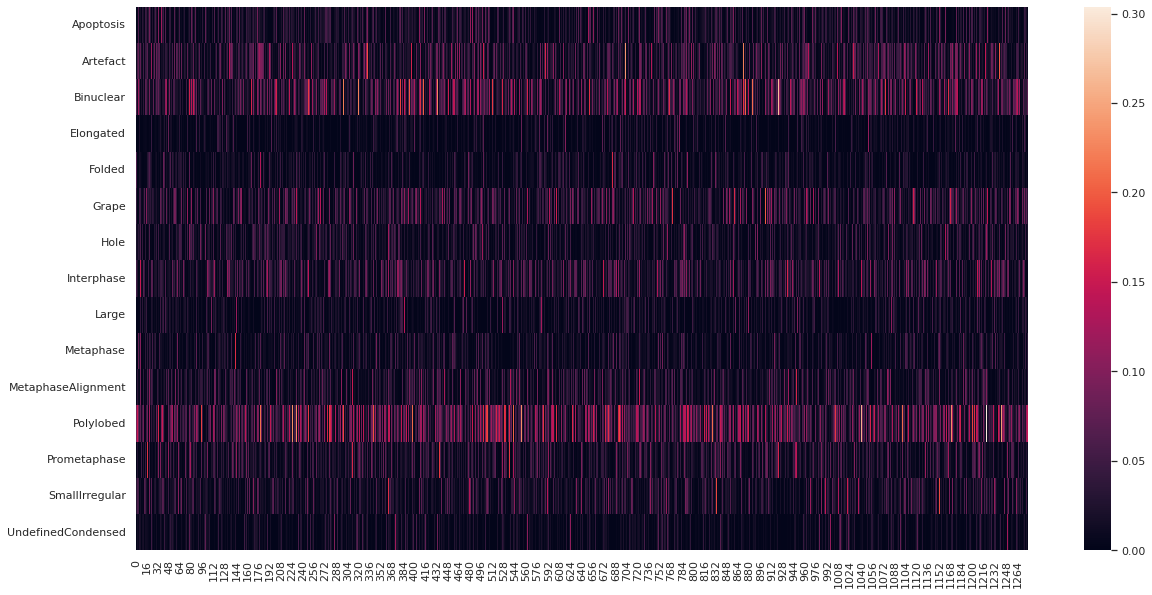

In [11]:
# display heatmap of average coefs
sns.set(rc={"figure.figsize": (20, 10)})
ax = sns.heatmap(data=average_coefs.T)

/home/roshankern/anaconda3/envs/2.ML_phenotypic_classification/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 0.98, 'Clustered Heatmap of Coefficients Matrix')

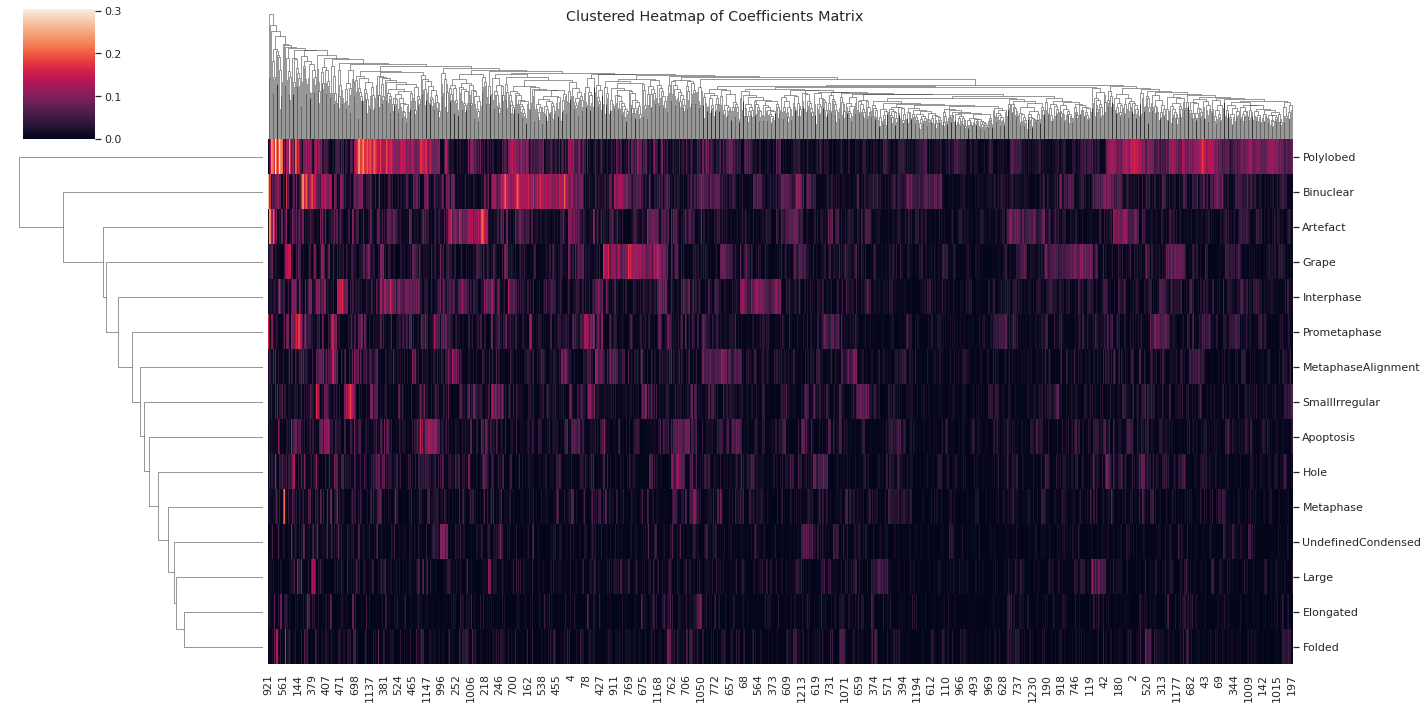

In [12]:
# display clustered heatmap of coefficients
ax = sns.clustermap(
    data=average_coefs.T, figsize=(20, 10), row_cluster=True, col_cluster=True
)
ax.fig.suptitle("Clustered Heatmap of Coefficients Matrix")

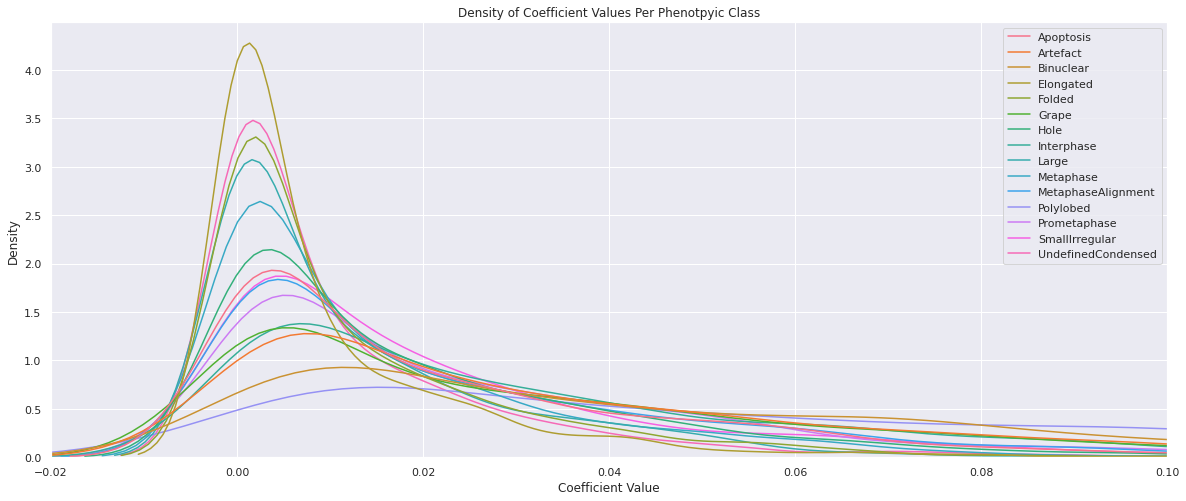

In [13]:
# display density plot for coefficient values of each class
sns.set(rc={"figure.figsize": (20, 8)})
plt.xlim(-0.02, 0.1)
plt.xlabel("Coefficient Value")
plt.ylabel("Density")
plt.title("Density of Coefficient Values Per Phenotpyic Class")
ax = sns.kdeplot(data=average_coefs)

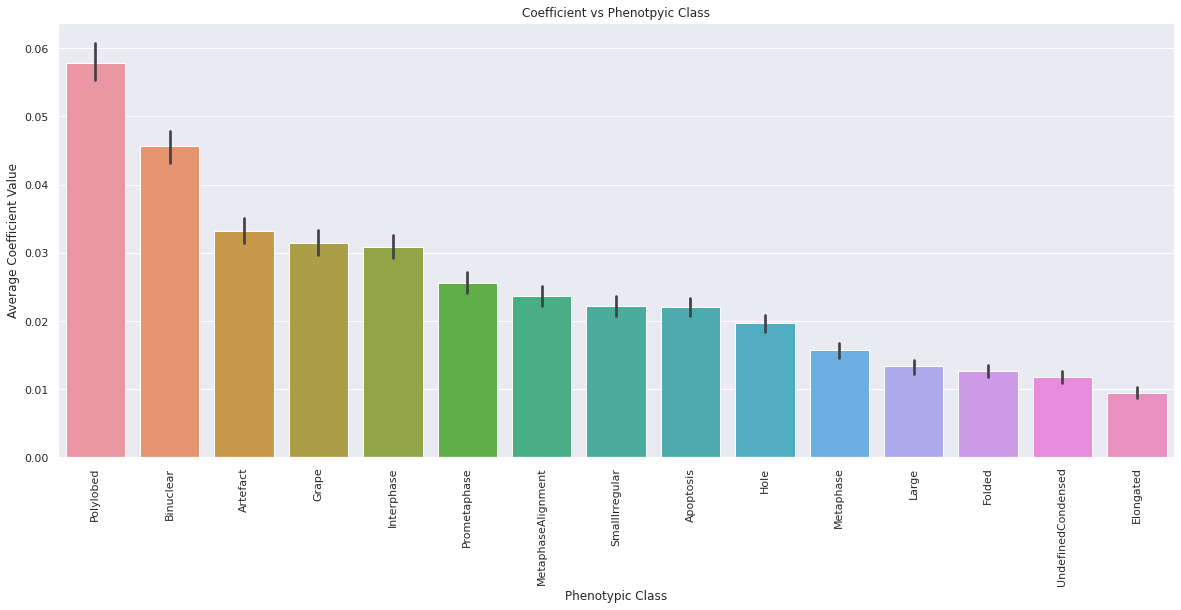

In [14]:
# display average coefficient value vs phenotypic class bar chart
pheno_class_ordered = average_coefs.reindex(
    average_coefs.mean().sort_values(ascending=False).index, axis=1
)
sns.set(rc={"figure.figsize": (20, 8)})
plt.xlabel("Phenotypic Class")
plt.ylabel("Average Coefficient Value")
plt.title("Coefficient vs Phenotpyic Class")
plt.xticks(rotation=90)
ax = sns.barplot(data=pheno_class_ordered)

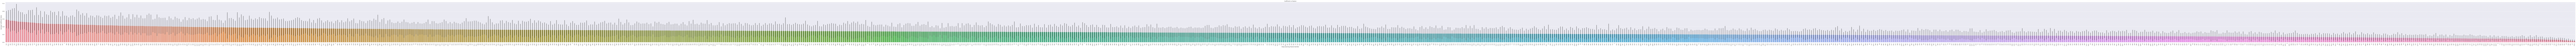

In [15]:
# display average coefficient value vs feature bar chart
feature_ordered = average_coefs.T.reindex(
    average_coefs.T.mean().sort_values(ascending=False).index, axis=1
)
sns.set(rc={"figure.figsize": (500, 8)})
plt.xlabel("Deep Learning Feature Number")
plt.ylabel("Average Coefficient Value")
plt.title("Coefficient vs Feature")
plt.xticks(rotation=90)
ax = sns.barplot(data=feature_ordered)